**GOOGLE SPEECH-TO-TEXT API**

In [ ]:
# Step 1: Install required libraries
!pip install google-cloud-speech pydub
!sudo apt update && sudo apt install ffmpeg

# Step 2: Upload credentials and audio file
from google.colab import files
import os

# Upload credentials
print("Upload Google Cloud credentials JSON:")
creds = files.upload()
creds_filename = list(creds.keys())[0]
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = f"/content/{creds_filename}"

# Upload audio file
print("\nUpload audio file:")
audio_file = files.upload()
audio_path = list(audio_file.keys())[0]

# Step 3: Audio chunking with silence detection
from pydub import AudioSegment, silence
import numpy as np

def chunk_audio(file_path):
    audio = AudioSegment.from_file(file_path)
    audio = audio.set_frame_rate(16000).set_channels(1)

    # Split on silence with optimized parameters for Bengali speech
    chunks = silence.split_on_silence(
        audio,
        min_silence_len=300,
        silence_thresh=-35,
        keep_silence=150,
        seek_step=10
    )

    # Export chunks with metadata
    chunk_info = []
    total_duration = 0

    for i, chunk in enumerate(chunks):
        chunk_name = f"chunk_{i}.wav"
        chunk.export(chunk_name, format="wav")
        duration = len(chunk) / 1000  # Duration in seconds
        chunk_info.append({
            "file": chunk_name,
            "start": total_duration,
            "end": total_duration + duration
        })
        total_duration += duration

    return chunk_info

# Create audio chunks
chunk_info = chunk_audio(audio_path)
print(f"Created {len(chunk_info)} audio chunks")

# Step 4: Transcribe chunks with proper Bengali configuration
from google.cloud import speech_v1p1beta1 as speech

def transcribe_chunk(chunk_path, chunk_start):
    client = speech.SpeechClient()

    with open(chunk_path, "rb") as audio_file:
        content = audio_file.read()

    audio = speech.RecognitionAudio(content=content)

    config = speech.RecognitionConfig(
        encoding=speech.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=16000,
        language_code="bn-IN",
        enable_automatic_punctuation=True,
        enable_word_time_offsets=True,
        # Modified configuration for Bengali support:
        use_enhanced=True,
        model="default"  # Remove "latest_long" as it's not supported for Bengali
    )

    operation = client.long_running_recognize(config=config, audio=audio)
    response = operation.result(timeout=300)

    # Adjust timestamps with chunk start time
    results = []
    for result in response.results:
        for word_info in result.alternatives[0].words:
            start = word_info.start_time.total_seconds() + chunk_start
            end = word_info.end_time.total_seconds() + chunk_start
            results.append({
                "start": start,
                "end": end,
                "text": word_info.word
            })

    return results

# Process all chunks
all_words = []
for chunk in chunk_info:
    print(f"Processing {chunk['file']}...")
    words = transcribe_chunk(chunk["file"], chunk["start"])
    all_words.extend(words)

# Step 5: Create phrases from words with natural pauses
transcript = []
current_phrase = []
current_start = 0
pause_threshold = 0.4  # Instead of 0.8 (500ms pause between words)

for i, word in enumerate(all_words):
    if not current_phrase:
        current_start = word['start']
        current_phrase.append(word['text'])
    else:
        prev_end = all_words[i-1]['end']
        pause_duration = word['start'] - prev_end

        if pause_duration > pause_threshold:
            transcript.append({
                "start": current_start,
                "end": prev_end,
                "text": " ".join(current_phrase)
            })
            current_phrase = [word['text']]
            current_start = word['start']
        else:
            current_phrase.append(word['text'])

# Add the last phrase
if current_phrase:
    transcript.append({
        "start": current_start,
        "end": all_words[-1]['end'],
        "text": " ".join(current_phrase)
    })

# Step 6: Format and save output
def format_timestamp(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = seconds % 60
    return f"{hours:02}:{minutes:02}:{seconds:06.3f}"

output_filename = "final_transcript.txt"
with open(output_filename, "w", encoding="utf-8") as f:
    for segment in transcript:
        start_time = format_timestamp(segment["start"])
        end_time = format_timestamp(segment["end"])
        f.write(f"[{start_time} - {end_time}] {segment['text']}\n")

# Download results
files.download(output_filename)

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
52 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InR

Saving secrets.json to secrets.json

Upload audio file:


Saving test_audio_3_meeting.mp3 to test_audio_3_meeting.mp3
Created 33 audio chunks
Processing chunk_0.wav...
Processing chunk_1.wav...
Processing chunk_2.wav...
Processing chunk_3.wav...
Processing chunk_4.wav...
Processing chunk_5.wav...
Processing chunk_6.wav...
Processing chunk_7.wav...
Processing chunk_8.wav...
Processing chunk_9.wav...
Processing chunk_10.wav...
Processing chunk_11.wav...
Processing chunk_12.wav...
Processing chunk_13.wav...
Processing chunk_14.wav...
Processing chunk_15.wav...
Processing chunk_16.wav...
Processing chunk_17.wav...
Processing chunk_18.wav...
Processing chunk_19.wav...
Processing chunk_20.wav...
Processing chunk_21.wav...
Processing chunk_22.wav...
Processing chunk_23.wav...
Processing chunk_24.wav...
Processing chunk_25.wav...
Processing chunk_26.wav...
Processing chunk_27.wav...
Processing chunk_28.wav...
Processing chunk_29.wav...
Processing chunk_30.wav...
Processing chunk_31.wav...
Processing chunk_32.wav...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import re

def parse_transcript(file_path):
    # Adjusted regex pattern to match the format in your file
    time_pattern = re.compile(
        r'\[(\d{2}:\d{2}:\d{2}\.\d{3})\s*-\s*(\d{2}:\d{2}:\d{2}\.\d{3})\]'
    )

    transcript_data = []

    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.read().splitlines()

    for line in lines:
        # Check if the line matches the time range pattern
        match = time_pattern.match(line)
        if match:
            start_time, end_time = match.groups()
            # Extract the text following the timestamp
            text = line[match.end():].strip()

            # Add the dictionary to our transcript_data list
            transcript_data.append({
                "start": start_time,
                "end": end_time,
                "name": "",  # Name is empty as requested
                "text": text
            })

    return transcript_data

if __name__ == "__main__":
    # Replace 'final_transcript.txt' with the actual file path
    file_path = '/content/final_transcript.txt'
    transcript = parse_transcript(file_path)
    for entry in transcript:
        print(entry)
    # print(transcript)


{'start': '00:00:00.000', 'end': '00:00:17.020', 'name': '', 'text': 'আমাদের বাংলা মিটিং প্ল্যাটফর্ম এর মূল ফোকাস হবে বাংলা বাংলা এবং ইংলিশ মিশ্রিত কথোপকথনের রেল টাইম ট্রানস্ক্রিপশন এটার জন্য আমাদের এনএলপি এবং টুডে মডেল উন্নত করতে হবে আপনারা মনে করেন সিস্টেম কিভাবে ব্যবহারকারী ফিডব্যাক গ্রহণ করবে'}
{'start': '00:00:17.750', 'end': '00:00:21.550', 'name': '', 'text': 'টেস্ট মডেল আপডেট এর জন্য আমাদের বাংলাদেশ থেকে বেটার সাথে প্রয়োজন'}
{'start': '00:00:21.990', 'end': '00:00:27.560', 'name': '', 'text': 'তাছাড়া বিয়ের ট্রান্সক্রিপশনের জন্য ব্যাটারি কম রাখতে রেসিপি ব্যবহার করতে হবে'}
{'start': '00:00:28.400', 'end': '00:01:11.720', 'name': '', 'text': 'ফিডব্যাকের জন্য আমার একটা ইন রাইটিং এবং ফিডব্যাক ফরম ডিলেট করতে পারি ব্যবহারকারী ফিডব্যাক নেওয়ার জন্য ইয়েটা সাহস রাখতে হবে প্রাথমিক ফিডব্যাক হিসেবে 1click রেটিং সিস্টেম রাখতে পারি এছাড়াও real-time ট্রানস্ক্রিপশন স্ক্রীন যাতে ক্লাসের ফ্রি হয় সেটার জন্য ডিজাইন করতে হবে ঠিক আছে তাহলে real-time ট্রানস্ক্রিপশন আর ইউ আর ডিসপ্লের মধ্যে সঠিক ব

In [ ]:
!pip install -q transformers accelerate bitsandbytes sentencepiece pandas matplotlib huggingface_hub

In [ ]:
# Step 2: Import necessary modules
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import pandas as pd
import matplotlib.pyplot as plt
from huggingface_hub import login

In [ ]:
# Step 3: Authenticate with Hugging Face
your_hf_token = "place your token here"  # Replace with your token
login(token=your_hf_token)

In [ ]:
transcript

[{'start': '00:00:00.000',
  'end': '00:00:17.020',
  'name': '',
  'text': 'আমাদের বাংলা মিটিং প্ল্যাটফর্ম এর মূল ফোকাস হবে বাংলা বাংলা এবং ইংলিশ মিশ্রিত কথোপকথনের রেল টাইম ট্রানস্ক্রিপশন এটার জন্য আমাদের এনএলপি এবং টুডে মডেল উন্নত করতে হবে আপনারা মনে করেন সিস্টেম কিভাবে ব্যবহারকারী ফিডব্যাক গ্রহণ করবে'},
 {'start': '00:00:17.750',
  'end': '00:00:21.550',
  'name': '',
  'text': 'টেস্ট মডেল আপডেট এর জন্য আমাদের বাংলাদেশ থেকে বেটার সাথে প্রয়োজন'},
 {'start': '00:00:21.990',
  'end': '00:00:27.560',
  'name': '',
  'text': 'তাছাড়া বিয়ের ট্রান্সক্রিপশনের জন্য ব্যাটারি কম রাখতে রেসিপি ব্যবহার করতে হবে'},
 {'start': '00:00:28.400',
  'end': '00:01:11.720',
  'name': '',
  'text': 'ফিডব্যাকের জন্য আমার একটা ইন রাইটিং এবং ফিডব্যাক ফরম ডিলেট করতে পারি ব্যবহারকারী ফিডব্যাক নেওয়ার জন্য ইয়েটা সাহস রাখতে হবে প্রাথমিক ফিডব্যাক হিসেবে 1click রেটিং সিস্টেম রাখতে পারি এছাড়াও real-time ট্রানস্ক্রিপশন স্ক্রীন যাতে ক্লাসের ফ্রি হয় সেটার জন্য ডিজাইন করতে হবে ঠিক আছে তাহলে real-time ট্রানস্ক্রিপশন

In [ ]:
# Step 4: Calculate speaker talk time
def calculate_talk_time(transcript):
    df = pd.DataFrame(transcript)
    df['duration'] = pd.to_datetime(df['end']) - pd.to_datetime(df['start'])
    df['duration_sec'] = df['duration'].dt.total_seconds()

    speaker_stats = df.groupby('name').agg(
        total_talk_time=('duration_sec', 'sum'),
        segments=('text', 'count'),
        avg_segment_length=('duration_sec', 'mean')
    ).reset_index()

    return speaker_stats

speaker_stats = calculate_talk_time(transcript)

<ipython-input-11-bb9bc8ae4192>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['duration'] = pd.to_datetime(df['end']) - pd.to_datetime(df['start'])
<ipython-input-11-bb9bc8ae4192>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['duration'] = pd.to_datetime(df['end']) - pd.to_datetime(df['start'])


In [ ]:
# Step 5: Sentiment Analysis using specialized model
sentiment_analyzer = pipeline(
    "text-classification",
    model="lxyuan/distilbert-base-multilingual-cased-sentiments-student",
    device=0  # Use GPU
)

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def analyze_sentiments(transcript):
    for segment in transcript:
        result = sentiment_analyzer(segment['text'])[0]
        segment['sentiment'] = result['label']
        segment['sentiment_score'] = result['score']
    return transcript

transcript_with_sentiment = analyze_sentiments(transcript)

In [ ]:
transcript_with_sentiment

[{'start': '00:00:00.000',
  'end': '00:00:17.020',
  'name': '',
  'text': 'আমাদের বাংলা মিটিং প্ল্যাটফর্ম এর মূল ফোকাস হবে বাংলা বাংলা এবং ইংলিশ মিশ্রিত কথোপকথনের রেল টাইম ট্রানস্ক্রিপশন এটার জন্য আমাদের এনএলপি এবং টুডে মডেল উন্নত করতে হবে আপনারা মনে করেন সিস্টেম কিভাবে ব্যবহারকারী ফিডব্যাক গ্রহণ করবে',
  'sentiment': 'positive',
  'sentiment_score': 0.5107699036598206},
 {'start': '00:00:17.750',
  'end': '00:00:21.550',
  'name': '',
  'text': 'টেস্ট মডেল আপডেট এর জন্য আমাদের বাংলাদেশ থেকে বেটার সাথে প্রয়োজন',
  'sentiment': 'positive',
  'sentiment_score': 0.5855133533477783},
 {'start': '00:00:21.990',
  'end': '00:00:27.560',
  'name': '',
  'text': 'তাছাড়া বিয়ের ট্রান্সক্রিপশনের জন্য ব্যাটারি কম রাখতে রেসিপি ব্যবহার করতে হবে',
  'sentiment': 'positive',
  'sentiment_score': 0.48225778341293335},
 {'start': '00:00:28.400',
  'end': '00:01:11.720',
  'name': '',
  'text': 'ফিডব্যাকের জন্য আমার একটা ইন রাইটিং এবং ফিডব্যাক ফরম ডিলেট করতে পারি ব্যবহারকারী ফিডব্যাক নেওয়ার জন্য ইয

In [ ]:
# Step 6: Action Item Generation using Mistral-7B
import torch

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_quant_type="nf4"
)

tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.3")
model = AutoModelForCausalLM.from_pretrained(
    "mistralai/Mistral-7B-Instruct-v0.3",
    device_map="auto",
    quantization_config=quantization_config,
    # Add these generation parameters
    do_sample=True,
    top_p=0.95,
    temperature=0.3,
    repetition_penalty=1.15
)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# def generate_action_items(transcript_text):
#     prompt = f"""<s>[INST] Analyze this meeting transcript and extract actionable items:
# {transcript_text}

# Format the output as:
# - Action Item: [description]
#   Responsible: [person]
#   Deadline: [timeframe]

# Include only actual concrete action items. [/INST]"""

#     inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
#     outputs = model.generate(**inputs, max_new_tokens=500)
#     return tokenizer.decode(outputs[0], skip_special_tokens=True)


def generate_action_items(transcript_text):
    prompt = f"""<s>[INST]
নিচের মিটিং ট্রান্সক্রিপ্ট বিশ্লেষণ করে কর্মপরিকল্পনা তৈরি করুন বাংলা ভাষায়:
{transcript_text}

ফরম্যাট:
- কর্মপরিকল্পনা: [বিবরণ]
  দায়িত্বপ্রাপ্ত: [ব্যক্তি]
  সময়সীমা: [সময়]

কেবলমাত্র বাস্তব কর্মপরিকল্পনা অন্তর্ভুক্ত করুন। উত্তর বাংলাতেই দিন। [/INST]"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=700)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Combine all text for processing
full_text = "\n".join([f"{seg['name']}: {seg['text']}" for seg in transcript])
action_items = generate_action_items(full_text)

/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1527: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
def generate_action_items(transcript_text):
    prompt = f"""<s>[INST]
Analyze the meeting transcript and generate action items in Bangla. Follow this format:
- Task: [বিবরণ]

Include only practical and relevant action items in the response. Use Bangla Unicode for the entire response.
Transcript:
{transcript_text}
[/INST]"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=700)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Combine all text for processing
full_text = "\n".join([f"{seg['text']}" for seg in transcript])  # Extract only the text field
action_items = generate_action_items(full_text)

# Output the cleaned response
print(action_items.split("[INST]")[-1].strip())

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Analyze the meeting transcript and generate action items in Bangla. Follow this format:
- Task: [বিবরণ]

Include only practical and relevant action items in the response. Use Bangla Unicode for the entire response. 
Transcript:
আমাদের বাংলা মিটিং প্ল্যাটফর্ম এর মূল ফোকাস হবে বাংলা বাংলা এবং ইংলিশ মিশ্রিত কথোপকথনের রেল টাইম ট্রানস্ক্রিপশন এটার জন্য আমাদের এনএলপি এবং টুডে মডেল উন্নত করতে হবে আপনারা মনে করেন সিস্টেম কিভাবে ব্যবহারকারী ফিডব্যাক গ্রহণ করবে
টেস্ট মডেল আপডেট এর জন্য আমাদের বাংলাদেশ থেকে বেটার সাথে প্রয়োজন
তাছাড়া বিয়ের ট্রান্সক্রিপশনের জন্য ব্যাটারি কম রাখতে রেসিপি ব্যবহার করতে হবে
ফিডব্যাকের জন্য আমার একটা ইন রাইটিং এবং ফিডব্যাক ফরম ডিলেট করতে পারি ব্যবহারকারী ফিডব্যাক নেওয়ার জন্য ইয়েটা সাহস রাখতে হবে প্রাথমিক ফিডব্যাক হিসেবে 1click রেটিং সিস্টেম রাখতে পারি এছাড়াও real-time ট্রানস্ক্রিপশন স্ক্রীন যাতে ক্লাসের ফ্রি হয় সেটার জন্য ডিজাইন করতে হবে ঠিক আছে তাহলে real-time ট্রানস্ক্রিপশন আর ইউ আর ডিসপ্লের মধ্যে সঠিক ব্যালেন্স রাখতে হবে এছাড়া আমাদের কালচারাল কন্টাক্ট মেইন্টে

In [ ]:
action_items

'\nনিচের মিটিং ট্রান্সক্রিপ্ট বিশ্লেষণ করে কর্মপরিকল্পনা তৈরি করুন বাংলা ভাষায়:\n: আমাদের বাংলা মিটিং প্ল্যাটফর্ম এর মূল ফোকাস হবে বাংলা বাংলা এবং ইংলিশ মিশ্রিত কথোপকথনের রেল টাইম ট্রানস্ক্রিপশন এটার জন্য আমাদের এনএলপি এবং টুডে মডেল উন্নত করতে হবে আপনারা মনে করেন সিস্টেম কিভাবে ব্যবহারকারী ফিডব্যাক গ্রহণ করবে\n: টেস্ট মডেল আপডেট এর জন্য আমাদের বাংলাদেশ থেকে বেটার সাথে প্রয়োজন\n: তাছাড়া বিয়ের ট্রান্সক্রিপশনের জন্য ব্যাটারি কম রাখতে রেসিপি ব্যবহার করতে হবে\n: ফিডব্যাকের জন্য আমার একটা ইন রাইটিং এবং ফিডব্যাক ফরম ডিলেট করতে পারি ব্যবহারকারী ফিডব্যাক নেওয়ার জন্য ইয়েটা সাহস রাখতে হবে প্রাথমিক ফিডব্যাক হিসেবে 1click রেটিং সিস্টেম রাখতে পারি এছাড়াও real-time ট্রানস্ক্রিপশন স্ক্রীন যাতে ক্লাসের ফ্রি হয় সেটার জন্য ডিজাইন করতে হবে ঠিক আছে তাহলে real-time ট্রানস্ক্রিপশন আর ইউ আর ডিসপ্লের মধ্যে সঠিক ব্যালেন্স রাখতে হবে এছাড়া আমাদের কালচারাল কন্টাক্ট মেইন্টেইন করতে হবে যেন বাংলা ইন্ডিয়ান স্টার ফ্রিজ সঠিকভাবে ট্রান্সক্রাইব হয় কালের কণ্ঠ হ্যান্ডেল করার জন্য এনএলপি মডেল টাউন করতে হবে করতে হব

In [ ]:
# Step 7: Generate Meeting Summary and Overall Sentiment
# def generate_meeting_summary(transcript_text):
#     prompt = f"""<s>[INST] Analyze this meeting transcript and create a comprehensive summary:
# {transcript_text}

# Include:
# 1. Key discussion points
# 2. Decisions made
# 3. Overall sentiment (positive/neutral/negative) with confidence score
# 4. Participant engagement analysis [/INST]"""

#     inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
#     outputs = model.generate(**inputs, max_new_tokens=1000)
#     return tokenizer.decode(outputs[0], skip_special_tokens=True)


def generate_meeting_summary(transcript_text):
    prompt = f"""<s>[INST]
মিটিং ট্রান্সক্রিপ্ট বিশ্লেষণ করে একটি বিস্তারিত সারাংশ তৈরি করুন বাংলা ভাষায়:
{transcript_text}

সারাংশে নিম্নলিখিত বিষয়গুলি অন্তর্ভুক্ত করুন:
১. প্রধান আলোচ্য বিষয়
২. গৃহীত সিদ্ধান্তসমূহ
৩. সামগ্রিক অনুভূতি (ইতিবাচক/নিরপেক্ষ/নেতিবাচক) সাথে আত্মবিশ্বাস স্কোর
৪. অংশগ্রহণকারীদের সম্পৃক্ততা বিশ্লেষণ

উত্তর অবশ্যই বাংলায় এবং ইউনিকোডে লিখতে হবে। [/INST]"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=1000)
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

meeting_summary = generate_meeting_summary(full_text)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
def generate_meeting_summary(transcript_text):
    prompt = f"""<s>[INST]
মিটিং ট্রান্সক্রিপ্ট বিশ্লেষণ করে একটি বিস্তারিত সারাংশ তৈরি করুন বাংলা ভাষায়:
{transcript_text}

সারাংশে নিম্নলিখিত বিষয়গুলি অন্তর্ভুক্ত করুন:
১. প্রধান আলোচ্য বিষয়
২. গৃহীত সিদ্ধান্তসমূহ
৩. সামগ্রিক অনুভূতি (ইতিবাচক/নিরপেক্ষ/নেতিবাচক) সাথে আত্মবিশ্বাস স্কোর
৪. অংশগ্রহণকারীদের সম্পৃক্ততা বিশ্লেষণ

উত্তর অবশ্যই বাংলায় এবং ইউনিকোডে লিখতে হবে। [/INST]"""

    inputs = tokenizer(prompt, return_tensors="pt").to("cuda")
    outputs = model.generate(**inputs, max_new_tokens=1000)
    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Format the summary output for clarity
    formatted_summary = "\n=== Meeting Summary ===\n"
    formatted_summary += "\n১. প্রধান আলোচ্য বিষয়:\n"
    formatted_summary += extract_section(summary, "প্রধান আলোচ্য বিষয়")
    formatted_summary += "\n\n২. গৃহীত সিদ্ধান্তসমূহ:\n"
    formatted_summary += extract_section(summary, "গৃহীত সিদ্ধান্তসমূহ")
    formatted_summary += "\n\n৩. সামগ্রিক অনুভূতি (ইতিবাচক/নিরপেক্ষ/নেতিবাচক) সাথে আত্মবিশ্বাস স্কোর:\n"
    formatted_summary += extract_section(summary, "সামগ্রিক অনুভূতি")
    formatted_summary += "\n\n৪. অংশগ্রহণকারীদের সম্পৃক্ততা বিশ্লেষণ:\n"
    formatted_summary += extract_section(summary, "অংশগ্রহণকারীদের সম্পৃক্ততা বিশ্লেষণ")

    return formatted_summary

def extract_section(summary, section_title):
    # Helper function to extract specific sections from the summary
    pattern = rf"{section_title}:(.*?)(\n\d|\Z)"
    match = re.search(pattern, summary, re.DOTALL)
    return match.group(1).strip() if match else "[তথ্য পাওয়া যায়নি]"

# Combine all text for processing
full_text = "\n".join([f"{seg['text']}" for seg in transcript])
meeting_summary = generate_meeting_summary(full_text)

# Output the formatted summary
print(meeting_summary)


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



=== Meeting Summary ===

১. প্রধান আলোচ্য বিষয়:
* বাংলাদেশের মিটিং প্ল্যাটফর্ম এর বাংলা ও ইংলিশ মিশ্রিত কথোপকথন রেল ট্রান্সক্রিপশন করা
   * টেস্ট মডেল আপডেট এর জন্য বাংলাদেশ থেকে বেটার সাথে প্রয়োজন
   * ব্যাটারি কম রাখতে রেসিপি ব্যবহার করতে হবে

২. গৃহীত সিদ্ধান্তসমূহ:
সিস্টেম কিভাবে ব্যবহারকারী ফিডব্যাক গ্রহণ করবে
   * এনএলপি এবং টুডে মডেল আপনারা মনে করেন সিস্টেম কিভাবে ব্যবহারকারী ফিডব্যাক গ্রহণ করবে

৩. সামগ্রিক অনুভূতি (ইতিবাচক/নিরপেক্ষ/নেতিবাচক) সাথে আত্মবিশ্বাস স্কোর:
[তথ্য পাওয়া যায়নি]

৪. অংশগ্রহণকারীদের সম্পৃক্ততা বিশ্লেষণ:
বিয়ের ট্রান্সক্রিপশনের জন্য ব্যাটারি কম রাখতে রেসিপি ব্যবহার করতে হব


In [ ]:
meeting_summary

'\nAnalyze the meeting transcript and create a detailed summary in Bangla. Ensure the structure includes section titles in English as follows:\n1. Key Discussion Points\n   প্রধান আলোচ্য বিষয়:\n   : আমাদের বাংলা মিটিং প্ল্যাটফর্ম এর মূল ফোকাস হবে বাংলা বাংলা এবং ইংলিশ মিশ্রিত কথোপকথনের রেল টাইম ট্রানস্ক্রিপশন এটার জন্য আমাদের এনএলপি এবং টুডে মডেল উন্নত করতে হবে আপনারা মনে করেন সিস্টেম কিভাবে ব্যবহারকারী ফিডব্যাক গ্রহণ করবে\n: টেস্ট মডেল আপডেট এর জন্য আমাদের বাংলাদেশ থেকে বেটার সাথে প্রয়োজন\n: তাছাড়া বিয়ের ট্রান্সক্রিপশনের জন্য ব্যাটারি কম রাখতে রেসিপি ব্যবহার করতে হবে\n: ফিডব্যাকের জন্য আমার একটা ইন রাইটিং এবং ফিডব্যাক ফরম ডিলেট করতে পারি ব্যবহারকারী ফিডব্যাক নেওয়ার জন্য ইয়েটা সাহস রাখতে হবে প্রাথমিক ফিডব্যাক হিসেবে 1click রেটিং সিস্টেম রাখতে পারি এছাড়াও real-time ট্রানস্ক্রিপশন স্ক্রীন যাতে ক্লাসের ফ্রি হয় সেটার জন্য ডিজাইন করতে হবে ঠিক আছে তাহলে real-time ট্রানস্ক্রিপশন আর ইউ আর ডিসপ্লের মধ্যে সঠিক ব্যালেন্স রাখতে হবে এছাড়া আমাদের কালচারাল কন্টাক্ট মেইন্টেইন করতে হবে যেন বাং

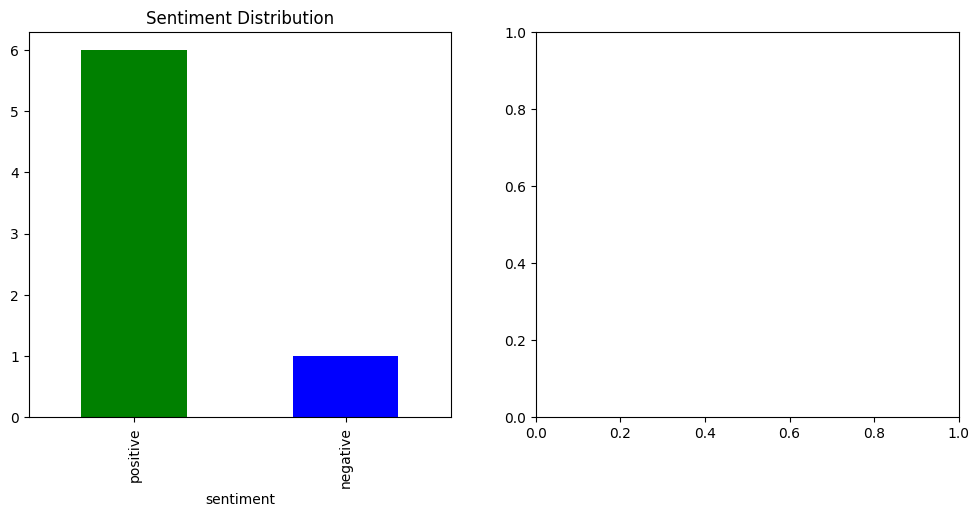

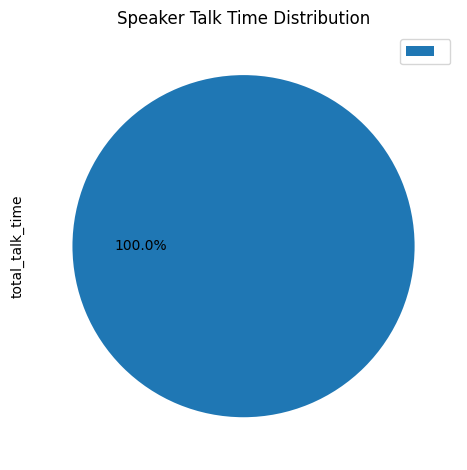

In [ ]:
# Step 8: Visualization
def visualize_meeting_metrics(transcript, speaker_stats):
    # Sentiment Distribution
    sentiments = pd.DataFrame(transcript)['sentiment'].value_counts()
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sentiments.plot(kind='bar', color=['green', 'blue', 'red'])
    plt.title('Sentiment Distribution')

    # Talk Time Distribution
    plt.subplot(1, 2, 2)
    speaker_stats.plot(kind='pie', y='total_talk_time', labels=speaker_stats['name'], autopct='%1.1f%%')
    plt.title('Speaker Talk Time Distribution')

    plt.tight_layout()
    plt.show()

visualize_meeting_metrics(transcript_with_sentiment, speaker_stats)

In [ ]:
# Step 9: Display Results
print("=== Action Items ===")
print(action_items.split("[/INST]")[-1].strip())

print("\n=== Meeting Summary ===")
print(meeting_summary.split("[/INST]")[-1].strip())

print("\n=== Speaker Statistics ===")
print(speaker_stats)

=== Action Items ===
Analyze the meeting transcript and generate action items in Bangla. Follow this format:
- Task: [বিবরণ]

Include only practical and relevant action items in the response. Use Bangla Unicode for the entire response. 
Transcript:
আমাদের বাংলা মিটিং প্ল্যাটফর্ম এর মূল ফোকাস হবে বাংলা বাংলা এবং ইংলিশ মিশ্রিত কথোপকথনের রেল টাইম ট্রানস্ক্রিপশন এটার জন্য আমাদের এনএলপি এবং টুডে মডেল উন্নত করতে হবে আপনারা মনে করেন সিস্টেম কিভাবে ব্যবহারকারী ফিডব্যাক গ্রহণ করবে
টেস্ট মডেল আপডেট এর জন্য আমাদের বাংলাদেশ থেকে বেটার সাথে প্রয়োজন
তাছাড়া বিয়ের ট্রান্সক্রিপশনের জন্য ব্যাটারি কম রাখতে রেসিপি ব্যবহার করতে হবে
ফিডব্যাকের জন্য আমার একটা ইন রাইটিং এবং ফিডব্যাক ফরম ডিলেট করতে পারি ব্যবহারকারী ফিডব্যাক নেওয়ার জন্য ইয়েটা সাহস রাখতে হবে প্রাথমিক ফিডব্যাক হিসেবে 1click রেটিং সিস্টেম রাখতে পারি এছাড়াও real-time ট্রানস্ক্রিপশন স্ক্রীন যাতে ক্লাসের ফ্রি হয় সেটার জন্য ডিজাইন করতে হবে ঠিক আছে তাহলে real-time ট্রানস্ক্রিপশন আর ইউ আর ডিসপ্লের মধ্যে সঠিক ব্যালেন্স রাখতে হবে এছাড়া আমাদের কালচ